In [1]:
import json
from os import listdir
import chess, chess.pgn, chess.engine
from chess.engine import Cp, Mate, MateGiven
from collections import Counter
from typing import Optional
from io import StringIO
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [2]:

class HelperClass:
    # returns all openings corresponding to the given list of files
    @staticmethod
    def getOpeningNames(username:str,files:list)->dict:
        #uses a map to get the opening names
        return list(map(lambda file : HelperClass.getGame(username,file)["opening"]["name"].split(":")[0],files))
    
    @staticmethod
    def getGame(username:str, file:str):
        return json.load(open("./games/{}/{}".format(username,file)))
    
    #returns a list of files where the username has the given color (if the color is not specified the function returns all user games)
    @staticmethod
    def getFiles(username:str,white:Optional[bool]=None):
        files = list()
        for file in listdir("./games/{}".format(username)):
            game = HelperClass.getGame(username=username,file=file)
            if white is not None:
                try:
                    if username==game["players"]["white" if white else "black"]["user"]["name"]:
                        files.append(file)
                except KeyError:
                    pass
            else:
                files.append(file)
        return files
    
    @staticmethod
    def readJSONGameToPGN(JSONGame):
        pgn = StringIO(JSONGame["moves"])
        game = chess.pgn.read_game(pgn)
        return game 
    
    @staticmethod
    def formatInfo(info):
            score = info["score"].white()
            mate_score = score.mate()
            centipawn_score =  score.score()/10 if score.score() is not None else None
            if "pv" in info:
                pv = HelperClass.formatMoves(info["pv"])
            else:
                pv = None
            return {
                "mate_score": mate_score,
                "centipawn_score": centipawn_score,
                "pv": HelperClass.formatMoves(pv)
            }               
    
    @staticmethod
    def formatMoves(pv):
        if pv is None:
            return ""
        return [move for move in pv]


In [3]:
class ChessAnalyser:
    def __init__(self) -> None:
        self.board = chess.Board()
        self.engine = chess.engine.SimpleEngine.popen_uci("./Stockfish/src/stockfish")
        
    def loadGameToBoard(self, game:chess.pgn.Game):
        self.board = game.board()
        for move in game.mainline_moves():
            self.board.push(move)

    def getSelfEval(self, depth:Optional[int]=20):
        info = self.engine.analyse(self.board, chess.engine.Limit(depth=depth))
        return info["score"]
    
    def getEvalInfos(self, board:chess.Board, depth:Optional[int]=20):
        return self.engine.analyse(board, chess.engine.Limit(depth=depth))
    
    def loadGameEval(self, game:chess.pgn.Game,depth:Optional[int]=20):
        board = chess.Board()
        movesInfo = list()
        board = game.board()
        for move in game.mainline_moves():
            board.push(move)
            movesInfo.append(self.getEvalInfos(board=board,depth=depth))
        return movesInfo
    
    #TODO consider player piece color
    def getFormattedInfos(self,game:chess.pgn.Game,depth:Optional[int]=20):
        infos = self.loadGameEval(game,depth)
        formattedInfos=[HelperClass.formatInfo(info) for info in infos]
        return formattedInfos

    @staticmethod
    def getEvals(formattedInfos):
        return [(100 if 0 < info["mate_score"] else -100)/10 if info["centipawn_score"] is None else info["centipawn_score"]/10  for info in formattedInfos]

    #TODO EVAL IS SOFT OF REALATIVE ?!
    def getBluders(self,game,depth:Optional[int]=20):
        BLUDER_THRESHHOLD = 2
        #if eval es dramatically different on the next turn
        evals = ChessAnalyser.getEvals(self.getFormattedInfos(game,depth))
        for i in range(1,len(evals)):
            difference = round(abs(evals[i-1]-evals[i]),2)
            if(difference > BLUDER_THRESHHOLD):
                print("{} -> {} moved [change in eval:{},eval before:{} - new eval:{}]".format(int(np.floor(i/2)),"black" if i%2 else "white",difference,evals[i-1],difference,evals[i]))
            
        
    def plotEvalGraph(self,game:chess.pgn.Game,depth:Optional[int]=20):

        evals = ChessAnalyser.getEvals(self.getFormattedInfos(game,depth))
        turns = len(evals)/2
        
        x=np.arange(0,turns,0.5)

        y1 = None
        y2 = None

        Y = evals

        fig, ax = plt.subplots()
        
        #ax.fill_between(x,y1,y2, alpha=0.5)
        ax.plot(x,Y,color="red")
        
        #TODO count two moves as one turn!
        ax.set(xlim=(0, turns),ylim=(-10, 10))
        plt.axhline(y=0)
        plt.xticks(np.arange(0,turns,2))
        plt.show()

    
    def getBoard(self):
        return self.board
    
    def getEngine(self):
        return self.engine
    
    def playNewGame(self):
        self.board = chess.Board()
        i = 0
        while not self.board.is_game_over():
            print(self.board)
            if i % 2 == 0:
                print(self.getSelfEval(1))
            result = self.engine.play(self.board,chess.engine.Limit(depth=10))
            self.board.push(result.move)
            i += 1
            
        self.board
        
    def quitEngine(self):
        self.engine.quit()

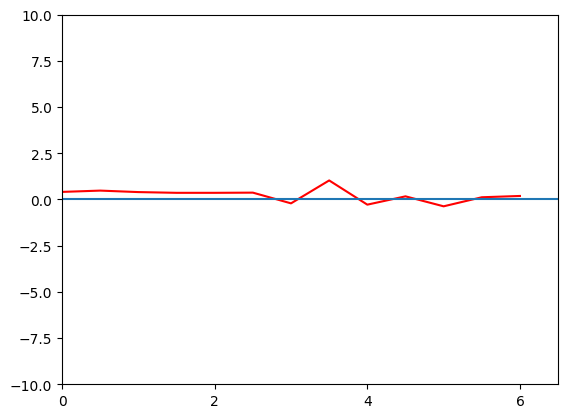

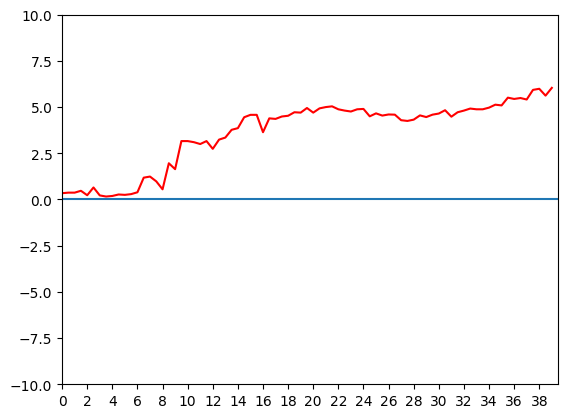

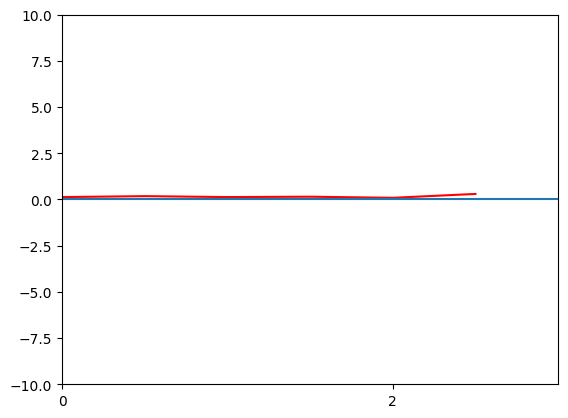

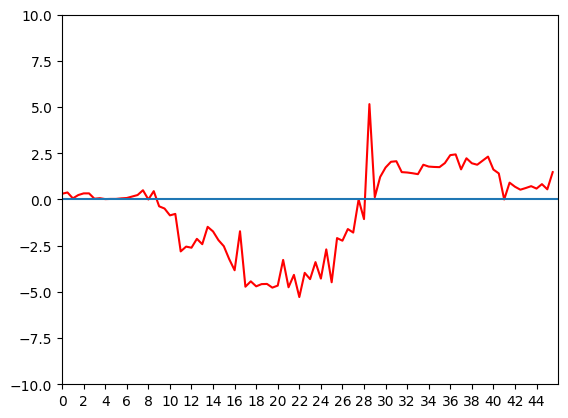

25 -> black moved [change in eval:2.43,eval before:-4.58 - new eval:2.43]
28 -> black moved [change in eval:5.24,eval before:-0.03 - new eval:5.24]
29 -> white moved [change in eval:5.08,eval before:5.21 - new eval:5.08]


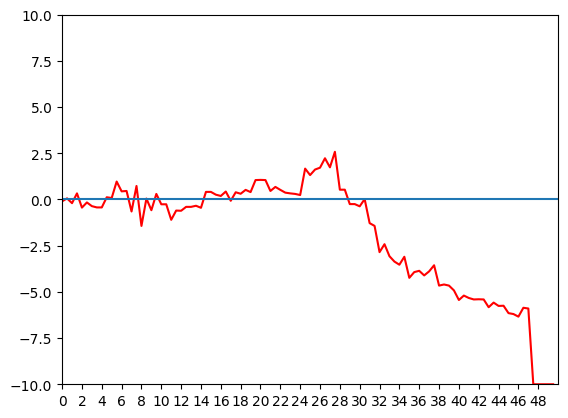

28 -> white moved [change in eval:2.44,eval before:2.88 - new eval:2.44]
46 -> white moved [change in eval:27.72,eval before:-6.38 - new eval:27.72]
47 -> white moved [change in eval:24.1,eval before:-34.1 - new eval:24.1]


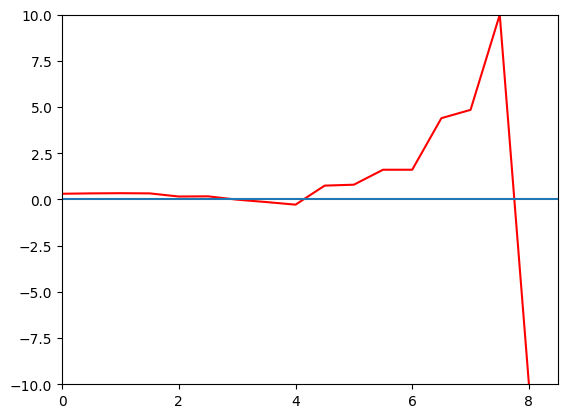

6 -> black moved [change in eval:3.39,eval before:1.61 - new eval:3.39]
7 -> black moved [change in eval:5.11,eval before:4.89 - new eval:5.11]
8 -> white moved [change in eval:20.0,eval before:10.0 - new eval:20.0]


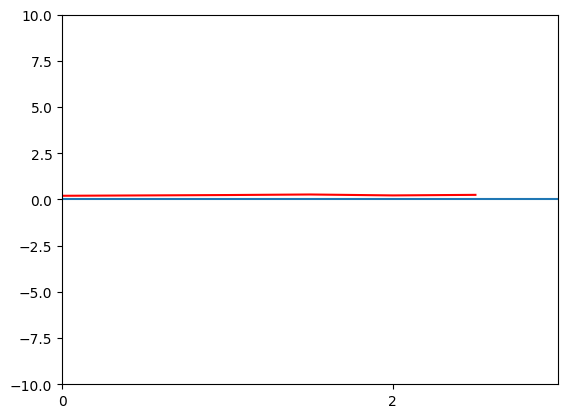

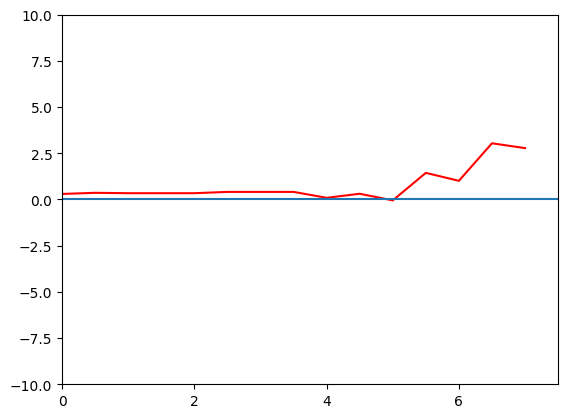

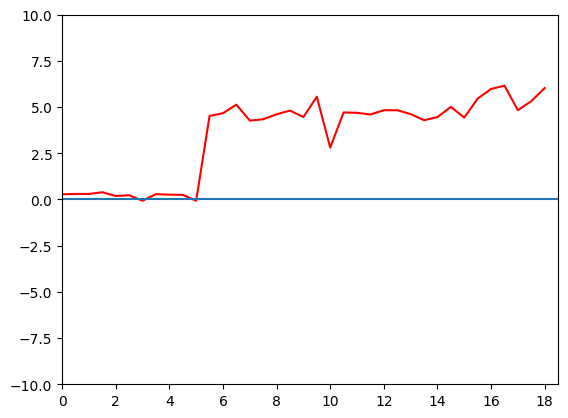

5 -> black moved [change in eval:4.74,eval before:-0.06999999999999999 - new eval:4.74]
10 -> white moved [change in eval:2.28,eval before:5.1 - new eval:2.28]


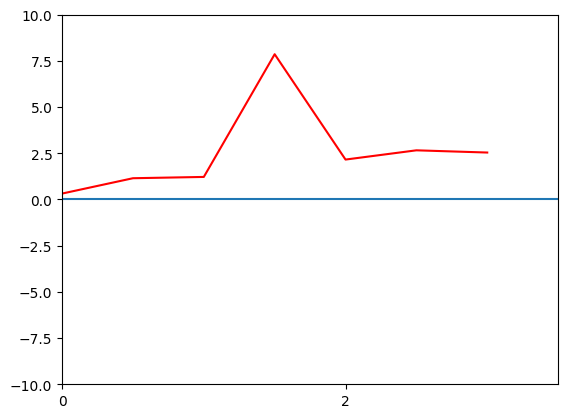

1 -> black moved [change in eval:6.39,eval before:1.23 - new eval:6.39]
2 -> white moved [change in eval:5.4,eval before:7.62 - new eval:5.4]


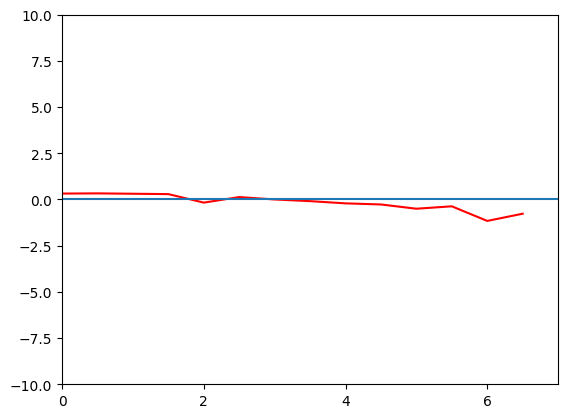

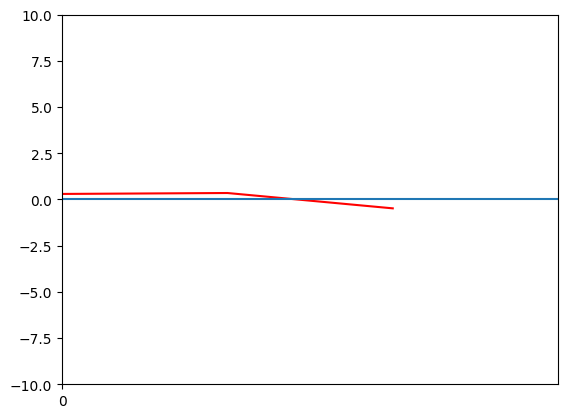

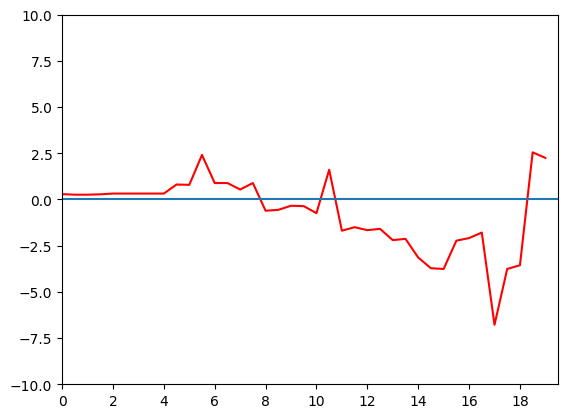

10 -> black moved [change in eval:2.86,eval before:-0.76 - new eval:2.86]
11 -> white moved [change in eval:3.81,eval before:2.1 - new eval:3.81]
17 -> white moved [change in eval:4.09,eval before:-1.8399999999999999 - new eval:4.09]
17 -> black moved [change in eval:2.26,eval before:-5.93 - new eval:2.26]
18 -> black moved [change in eval:6.49,eval before:-3.85 - new eval:6.49]


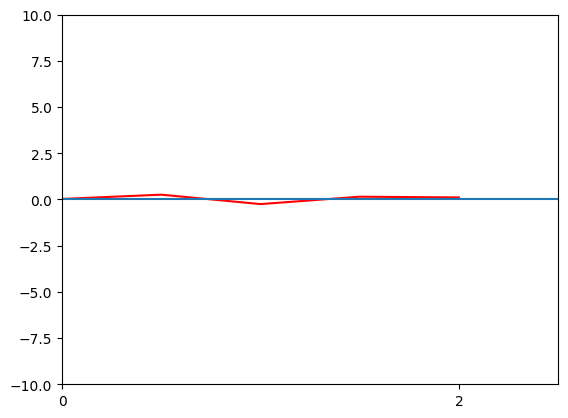

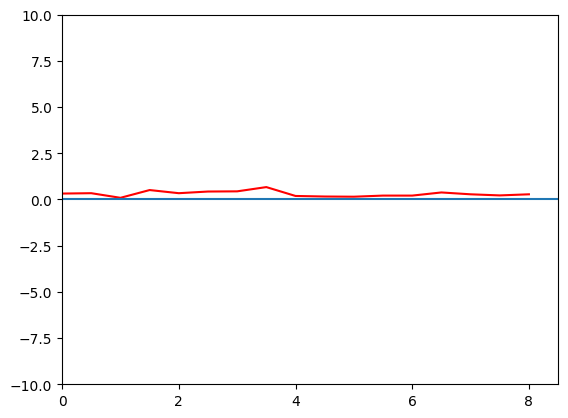

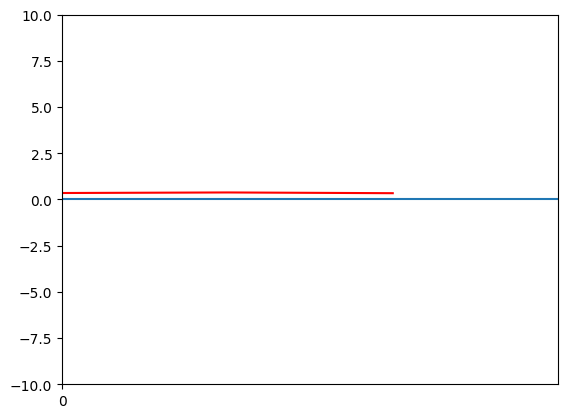

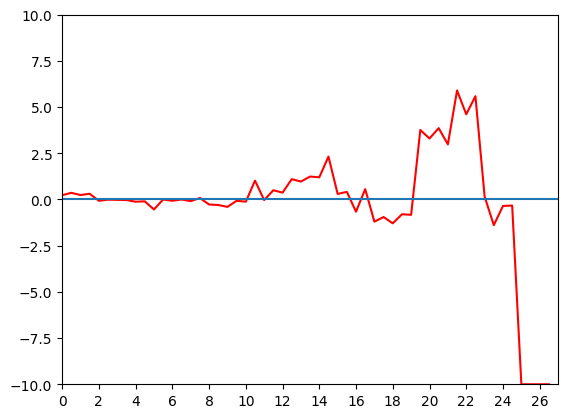

19 -> black moved [change in eval:4.22,eval before:-0.8800000000000001 - new eval:4.22]
21 -> black moved [change in eval:2.78,eval before:3.12 - new eval:2.78]
23 -> white moved [change in eval:5.8,eval before:5.4799999999999995 - new eval:5.8]
25 -> white moved [change in eval:9.16,eval before:-0.8400000000000001 - new eval:9.16]


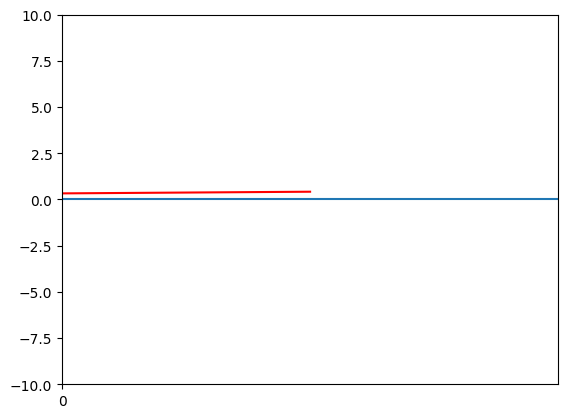

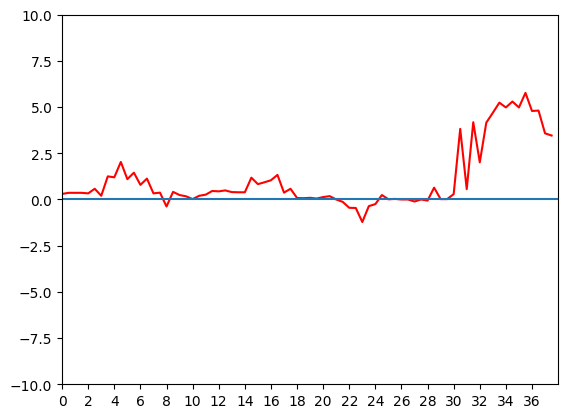

30 -> black moved [change in eval:3.8,eval before:0.2 - new eval:3.8]
31 -> white moved [change in eval:3.46,eval before:4.0 - new eval:3.46]
31 -> black moved [change in eval:3.68,eval before:0.54 - new eval:3.68]
32 -> white moved [change in eval:2.18,eval before:4.220000000000001 - new eval:2.18]
32 -> black moved [change in eval:2.35,eval before:2.04 - new eval:2.35]


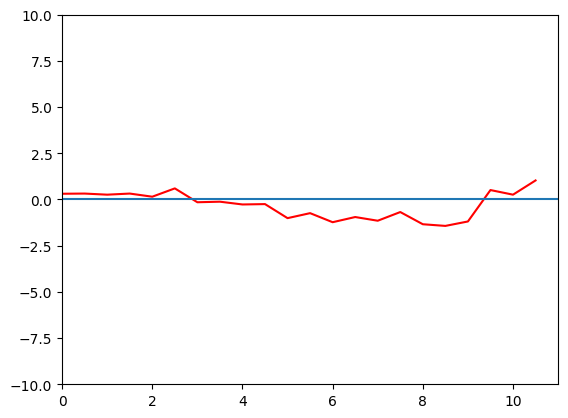

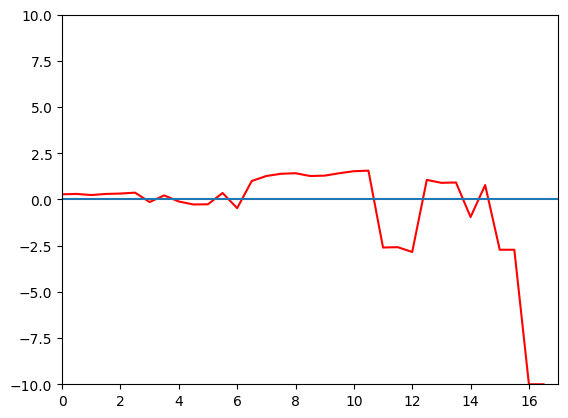

11 -> white moved [change in eval:3.89,eval before:1.55 - new eval:3.89]
12 -> black moved [change in eval:4.39,eval before:-3.37 - new eval:4.39]
15 -> white moved [change in eval:3.52,eval before:0.8 - new eval:3.52]
16 -> white moved [change in eval:7.28,eval before:-2.7199999999999998 - new eval:7.28]


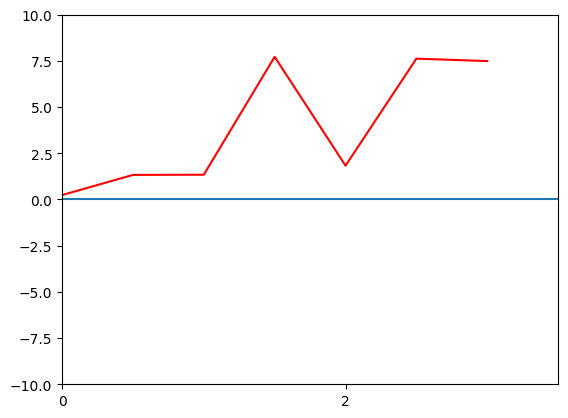

1 -> black moved [change in eval:6.63,eval before:1.17 - new eval:6.63]
2 -> white moved [change in eval:5.94,eval before:7.8 - new eval:5.94]
2 -> black moved [change in eval:5.6,eval before:1.86 - new eval:5.6]


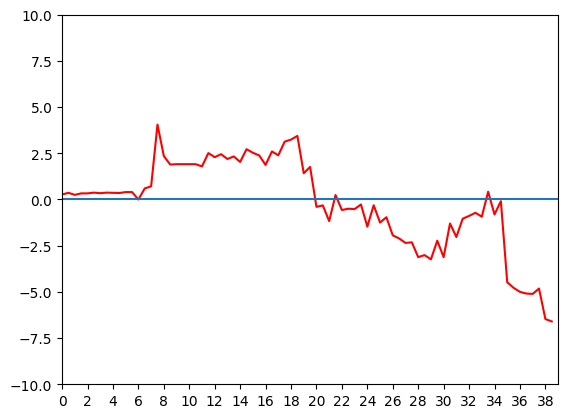

7 -> black moved [change in eval:3.04,eval before:0.75 - new eval:3.04]
8 -> white moved [change in eval:2.12,eval before:3.79 - new eval:2.12]
35 -> white moved [change in eval:5.05,eval before:-0.06 - new eval:5.05]


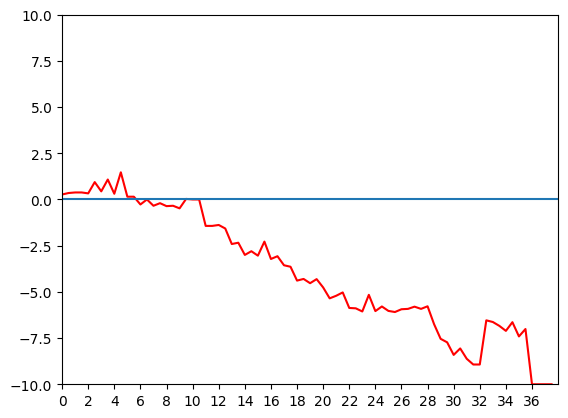

32 -> black moved [change in eval:2.57,eval before:-9.41 - new eval:2.57]
36 -> white moved [change in eval:2.64,eval before:-7.359999999999999 - new eval:2.64]


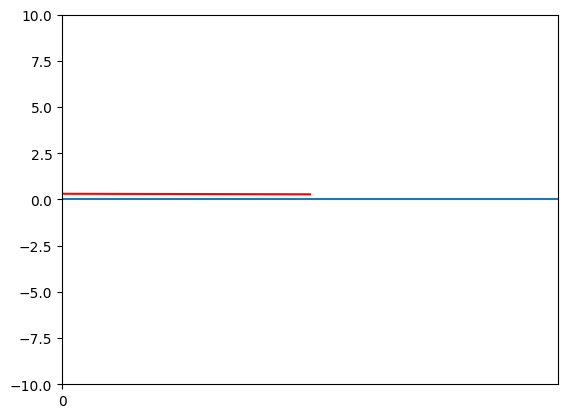

In [4]:
analyser = ChessAnalyser()

# JSONgame = HelperClass.getGame("Triumpfole",helperClass.getFiles("Triumpfole",True)[3])
# game = analyser.readJSONGameToPGN(JSONgame)
# analyser.loadGameToBoard(game)

#print(analyser.getSelfEval(2))
# analyser.plotEvalGraph(game=game,depth=10)
#analyser.getBoard()

for file in HelperClass.getFiles(username="Triumpfole"):
    JSONgame = HelperClass.getGame("Triumpfole", file)
    game = HelperClass.readJSONGameToPGN(JSONgame)
    analyser.plotEvalGraph(game=game,depth=10)
    analyser.getBluders(game=game,depth=10)

# analyser.loadGameEval(game,10)


In [5]:
# if __name__ == "__main__":
#     helperClass = HelperClass()
#     #gets a saved game
#     game = helperClass.getGame("Triumpfole",helperClass.getFiles("Triumpfole",True)[0])
    
#     analyser = ChessAnalyser()
#     #updates the position on the board to the end position
#     analyser.readJSONGameToPGN(game)
    
#     #evaluates the end position
#     print(analyser.getEval(2))
    
#     analyser.playNewGame()
    
#     #quits the engine
#     analyser.quitEngine()